In [1]:
import torch
import torch.nn as nn

In [2]:
!gdown 1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO
!gdown 1tADa7tvzVq5Lj7tDsYaHZY_i2ff8I-7E

Downloading...
From (original): https://drive.google.com/uc?id=1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO
From (redirected): https://drive.google.com/uc?id=1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO&confirm=t&uuid=36f01d60-fe58-4c2a-984a-782369944231
To: /content/COST_X_train.pt
100% 768M/768M [00:04<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tADa7tvzVq5Lj7tDsYaHZY_i2ff8I-7E
To: /content/COST_y_train.pt
100% 241k/241k [00:00<00:00, 122MB/s]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Chosen device:', device)

Chosen device: cuda


In [4]:
X_train = torch.load('COST_X_train.pt')
X_train.shape

torch.Size([15000, 64, 100, 2])

In [5]:
Y_train = torch.load('COST_y_train.pt')
Y_train.shape

torch.Size([15000, 2])

## Autoencoder

In [7]:
X = X_train[::1]
Y = Y_train[::1]

X = X.permute(0, 3, 1, 2)

print(X.shape, Y.shape)

torch.Size([15000, 2, 64, 100]) torch.Size([15000, 2])


In [9]:
# BASIC 2

class Autoencoder2D(nn.Module):
    def __init__(self):
        super(Autoencoder2D, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1),  # 16x32x50
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 32x16x25
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x8x13
            nn.ReLU(True)
        )


        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x16x26
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x32x52
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=(1, 3), output_padding=1),  # 2x64x104
#             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder2D()


print(model)


Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)


In [10]:
model(X).shape

torch.Size([15000, 2, 64, 100])

In [11]:
model.to(device)

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming X and Y are your input and output tensors respectively

# Create a TensorDataset
dataset = TensorDataset(X, Y)

# Define batch size
batch_size = 30

# Create DataLoader objects for handling batches
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [13]:
history = []

In [16]:
# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        batch_x = batch_x.to(device)
        output = model(batch_x)

        loss = criterion(output, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    history.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.05651068686787039
Epoch 2, Loss: 0.00519506790721789
Epoch 3, Loss: 0.0034861145657487215
Epoch 4, Loss: 0.0027009770290460436
Epoch 5, Loss: 0.0022470558944623917
Epoch 6, Loss: 0.001908719593891874
Epoch 7, Loss: 0.0016954502735752612
Epoch 8, Loss: 0.0015080141436774283
Epoch 9, Loss: 0.0014088165289722382
Epoch 10, Loss: 0.0012678373249946162
Epoch 11, Loss: 0.0011817434986587613
Epoch 12, Loss: 0.0010569656861480325
Epoch 13, Loss: 0.0010520776432240383
Epoch 14, Loss: 0.0009251541196135804
Epoch 15, Loss: 0.0009471968847792596
Epoch 16, Loss: 0.0008021226697601378
Epoch 17, Loss: 0.0008063047784380615
Epoch 18, Loss: 0.0007873959194403142
Epoch 19, Loss: 0.0007568415210116654
Epoch 20, Loss: 0.000668849288020283
Epoch 21, Loss: 0.0006622133608907461
Epoch 22, Loss: 0.0006643532521557063
Epoch 23, Loss: 0.0005980534698464908
Epoch 24, Loss: 0.0005912086254102178
Epoch 25, Loss: 0.000606321377970744
Epoch 26, Loss: 0.0005776029937551357
Epoch 27, Loss: 0.0005507793

In [ ]:
# # Define your loss function
# criterion = nn.MSELoss()

# # Define your optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Training loop
# num_epochs = 30
# for epoch in range(num_epochs):
#     total_loss = 0
#     for batch_x, batch_y in train_loader:
#         optimizer.zero_grad()

#         output = model(batch_x)

#         output_fft_complex = torch.fft.fft(output)
#         output_fft = output_fft_complex.real**2 + output_fft_complex.imag**2

#         batch_x_fft_complex = torch.fft.fft(batch_x)
#         batch_x_fft = batch_x_fft_complex.real**2 + batch_x_fft_complex.imag**2

#         loss_ = criterion(output, batch_x)
#         loss_fft = criterion(output_fft, batch_x_fft)
#         loss = loss_ + loss_fft
#         loss = loss_fft
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     history.append(total_loss)
#     print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


In [17]:
import matplotlib.pyplot as plt

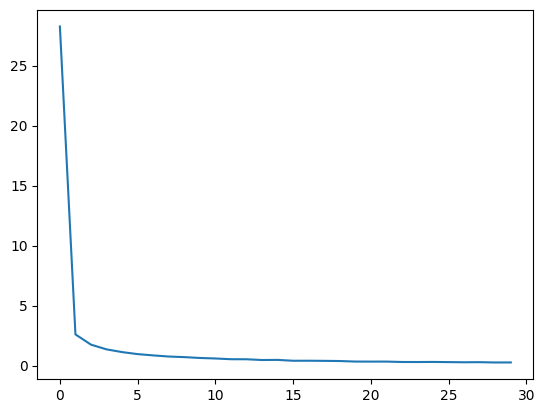

In [18]:
plt.plot(history[0:])

In [19]:
model_basic = model
model_basic

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [20]:
model_main = model

In [21]:
try:
    X_enc_main = X_enc
except:
    2

In [33]:
samplegap = 10

In [28]:
X_train = X_train.to('cpu')

In [29]:
with torch.no_grad():
    X_enc = model_main.to('cpu').encoder(X_train[::1].permute(0, 3, 1, 2))
print(X_enc.shape)
X_enc = torch.flatten(X_enc, start_dim =1)
print(X_enc.shape)

torch.Size([15000, 64, 8, 13])
torch.Size([15000, 6656])


In [30]:
X_enc.device

device(type='cpu')

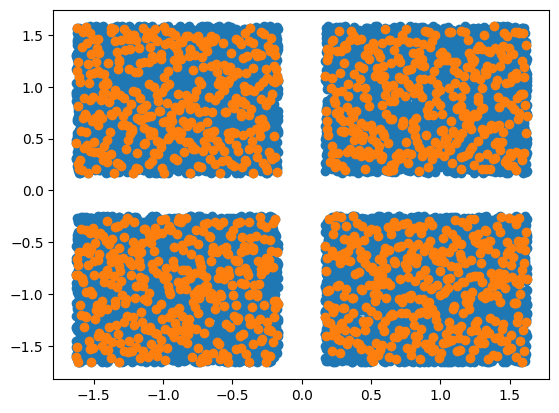

torch.Size([1500, 6656])


In [34]:
plt.scatter(Y_train[:, 0], Y_train[:, 1])
plt.scatter(Y_train[::samplegap, 0], Y_train[::samplegap, 1])

plt.show()

print(X_enc[::samplegap].shape)

In [53]:
torch.save(model_main.state_dict, 'model_main_state_dict.pt')

In [50]:
model_main

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [37]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, max_depth=20)
model.fit(X_enc, Y_train)

RandomForestRegressor(max_depth=20, n_estimators=10)

In [38]:
Y_pred = model.predict(X_enc)

In [44]:
!pip install joblib

In [45]:
import joblib

In [48]:
Y_pred2 = model.predict(X_enc[::samplegap])

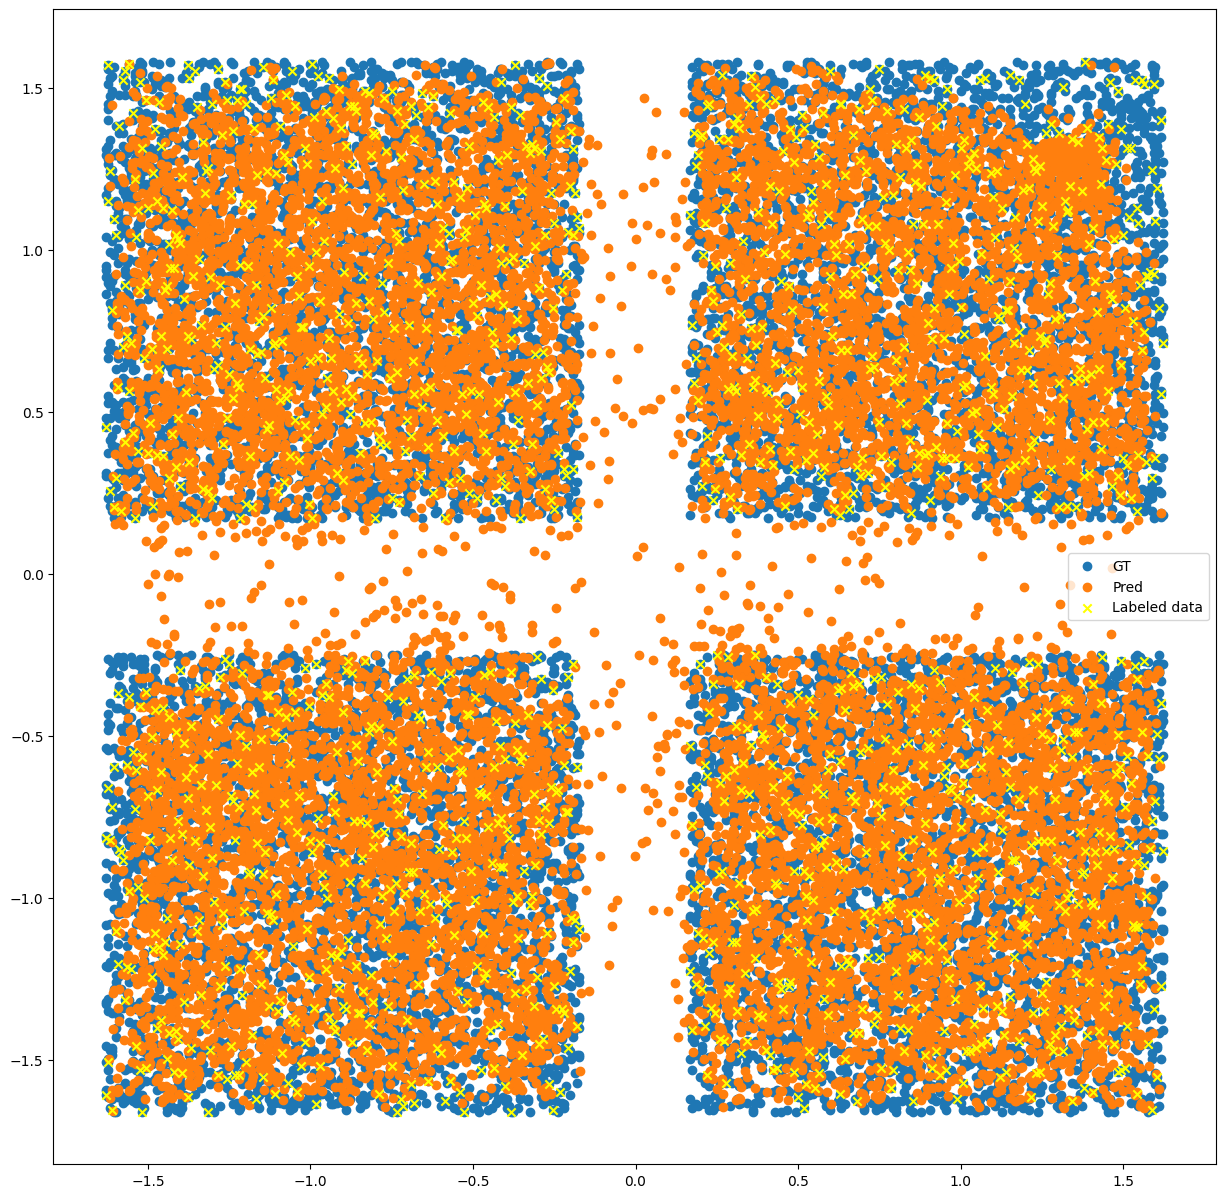

In [66]:
plt.figure(figsize = (15, 15))
plt.scatter(Y_train[:, 0], Y_train[:, 1], label = "GT")


plt.scatter(Y_pred[:, 0], Y_pred[:, 1], label = "Pred")
plt.scatter(Y_train[::samplegap, 0], Y_train[::samplegap, 1], label = "Labeled data", marker = 'x', color = 'yellow')

plt.legend()
plt.show()

In [54]:
import pickle

# Define the filename
filename = 'randomforest_model.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(model, file)


In [55]:
filename = 'randomforest_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)